# 프로젝트: Kaggle

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# 모델 들고오기 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('good')

good


### 데이터 전처리 해보기 !

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

### train/test 안에 있는 date 날짜를 정수 6자리 까지 조정 및 price/id 칼럼 삭제

In [3]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [4]:
y = train['price']
del train['price']
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
y #price 데이터 확인하기 

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

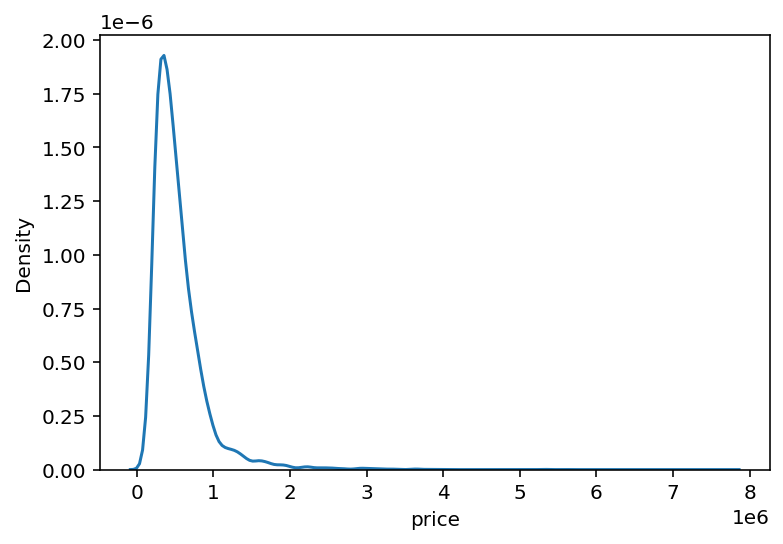

In [7]:
# seaborn의 `kdeplot`활용하기위해 검색 후 실행 

sns.kdeplot(y)
plt.show()

### 왼쪽으로 치우쳐 져 있어 lgo1p 함수를 통해 변환

In [8]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

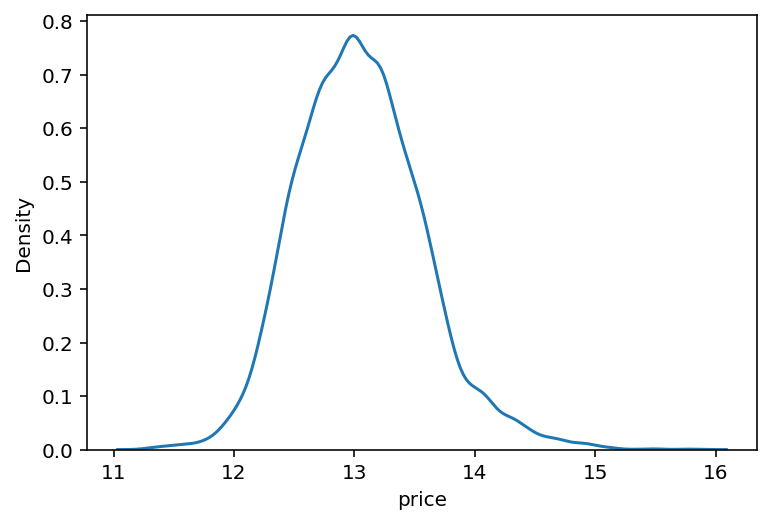

In [9]:
sns.kdeplot(y)
plt.show()

In [10]:
train.info() #전체 데이터의 자료형을 확인하기!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

### 결측치 시각화 및 확인!

<AxesSubplot:>

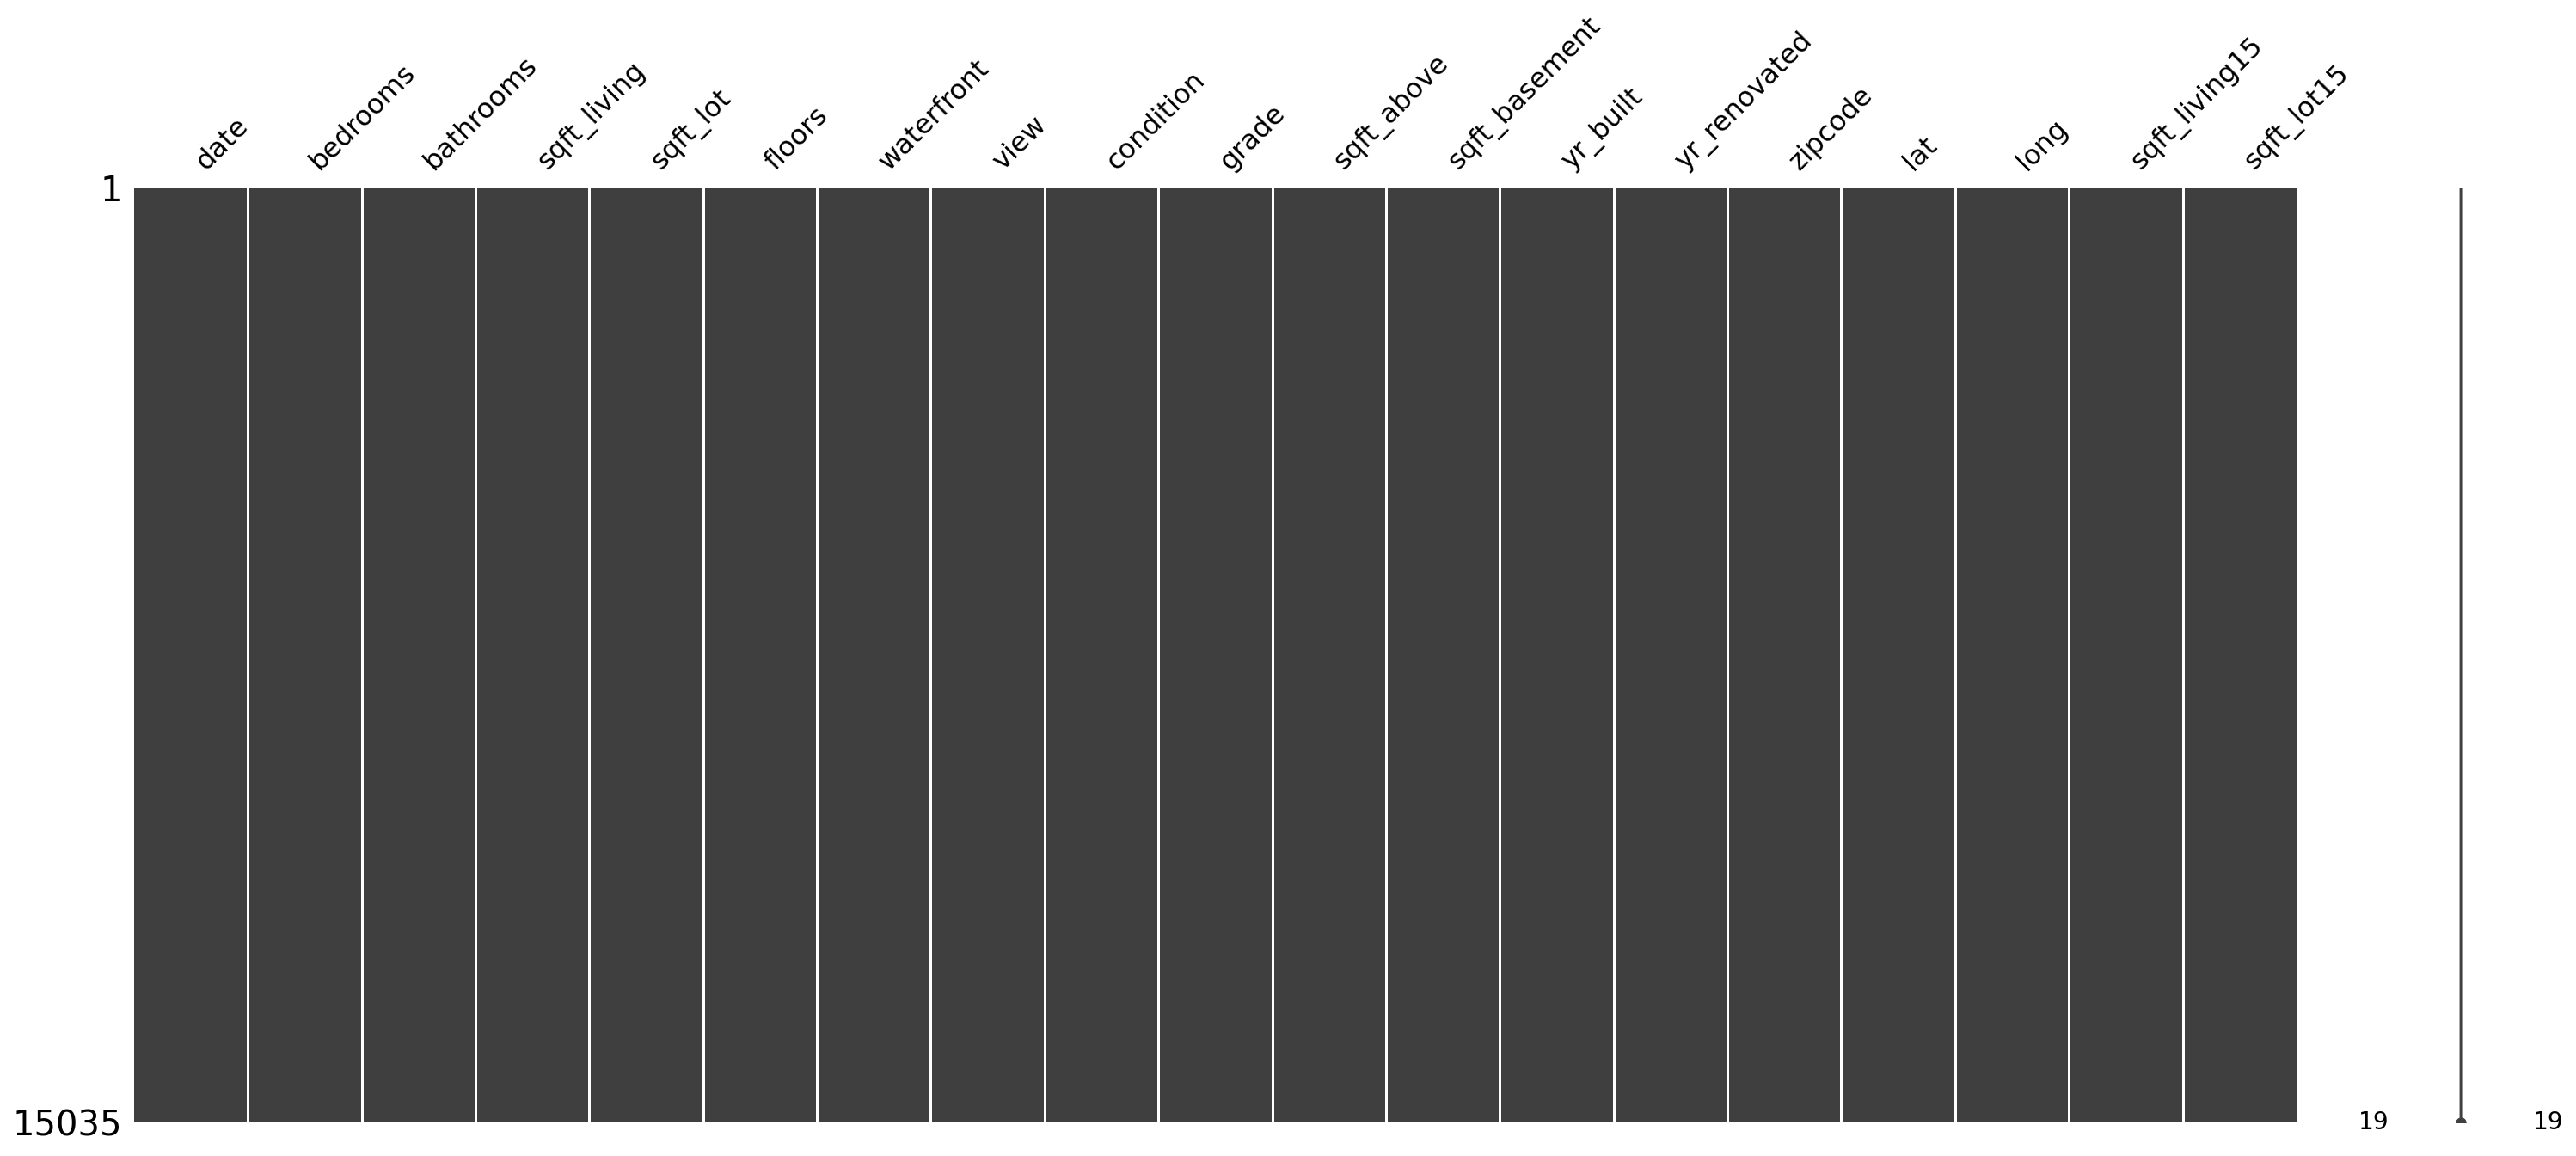

In [11]:
msno.matrix(train)

In [12]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 전체 그래프 그려보기!

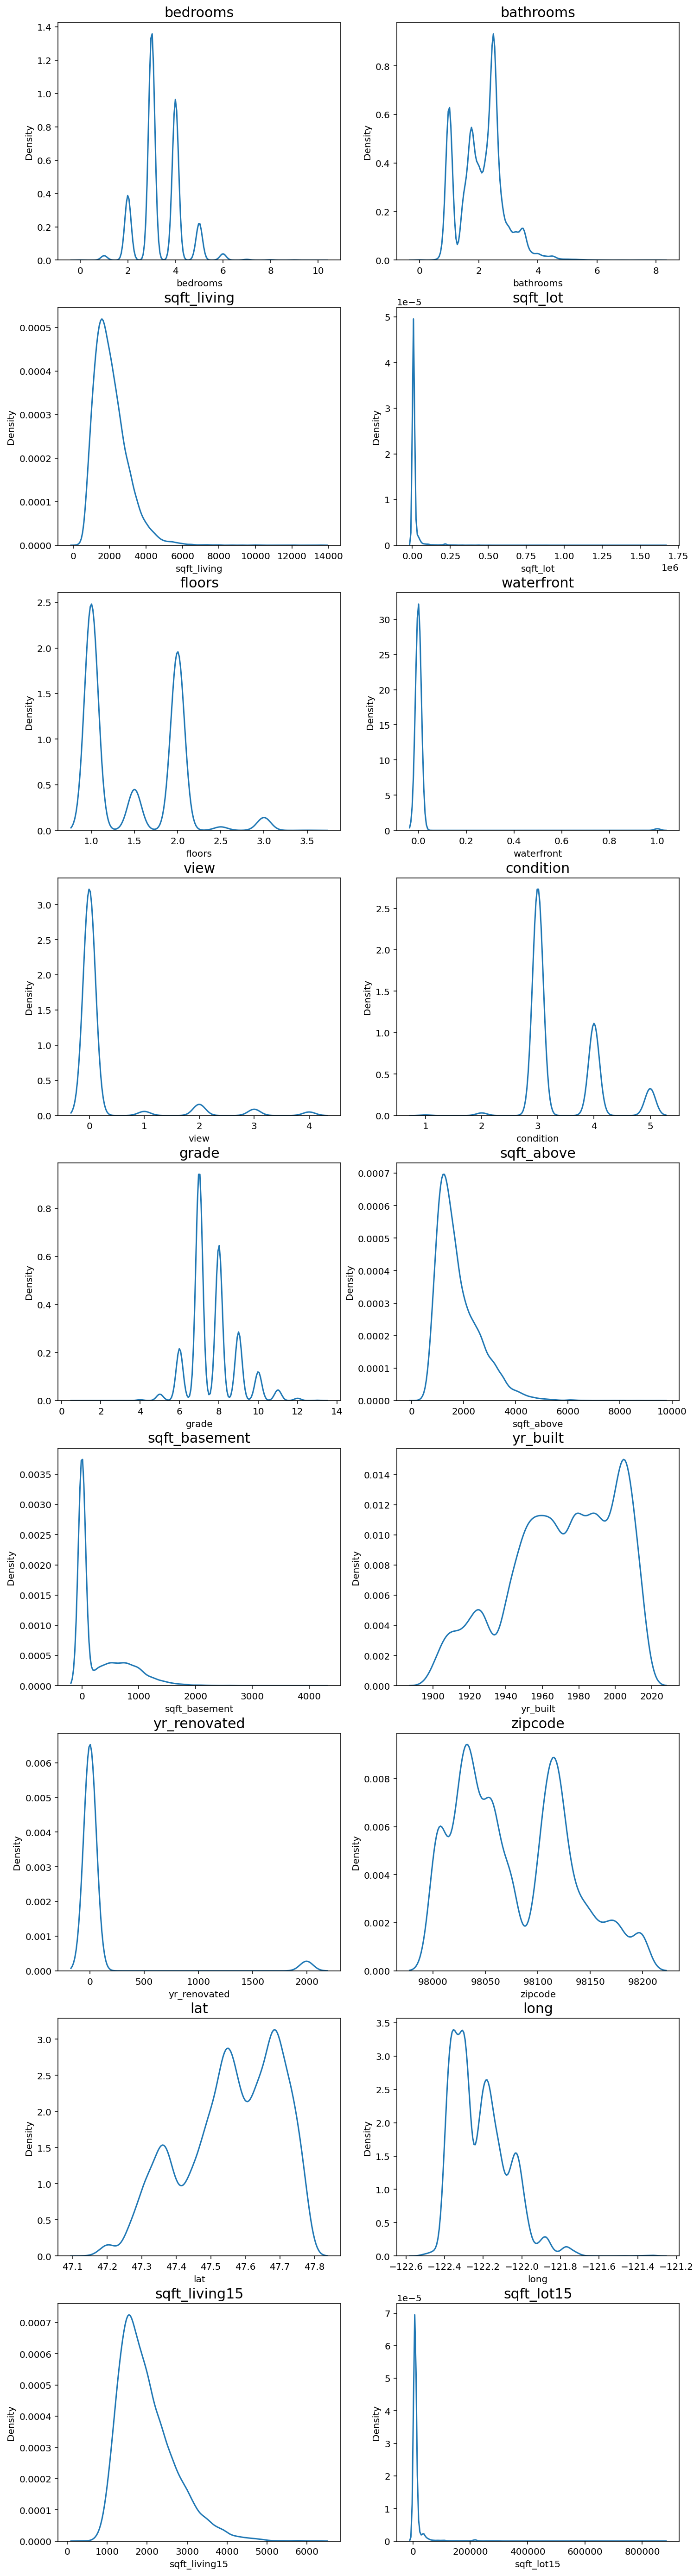

In [13]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   

count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

### 왼쪽으로 치우친를 분포 정규분포 로 만들기!

In [14]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

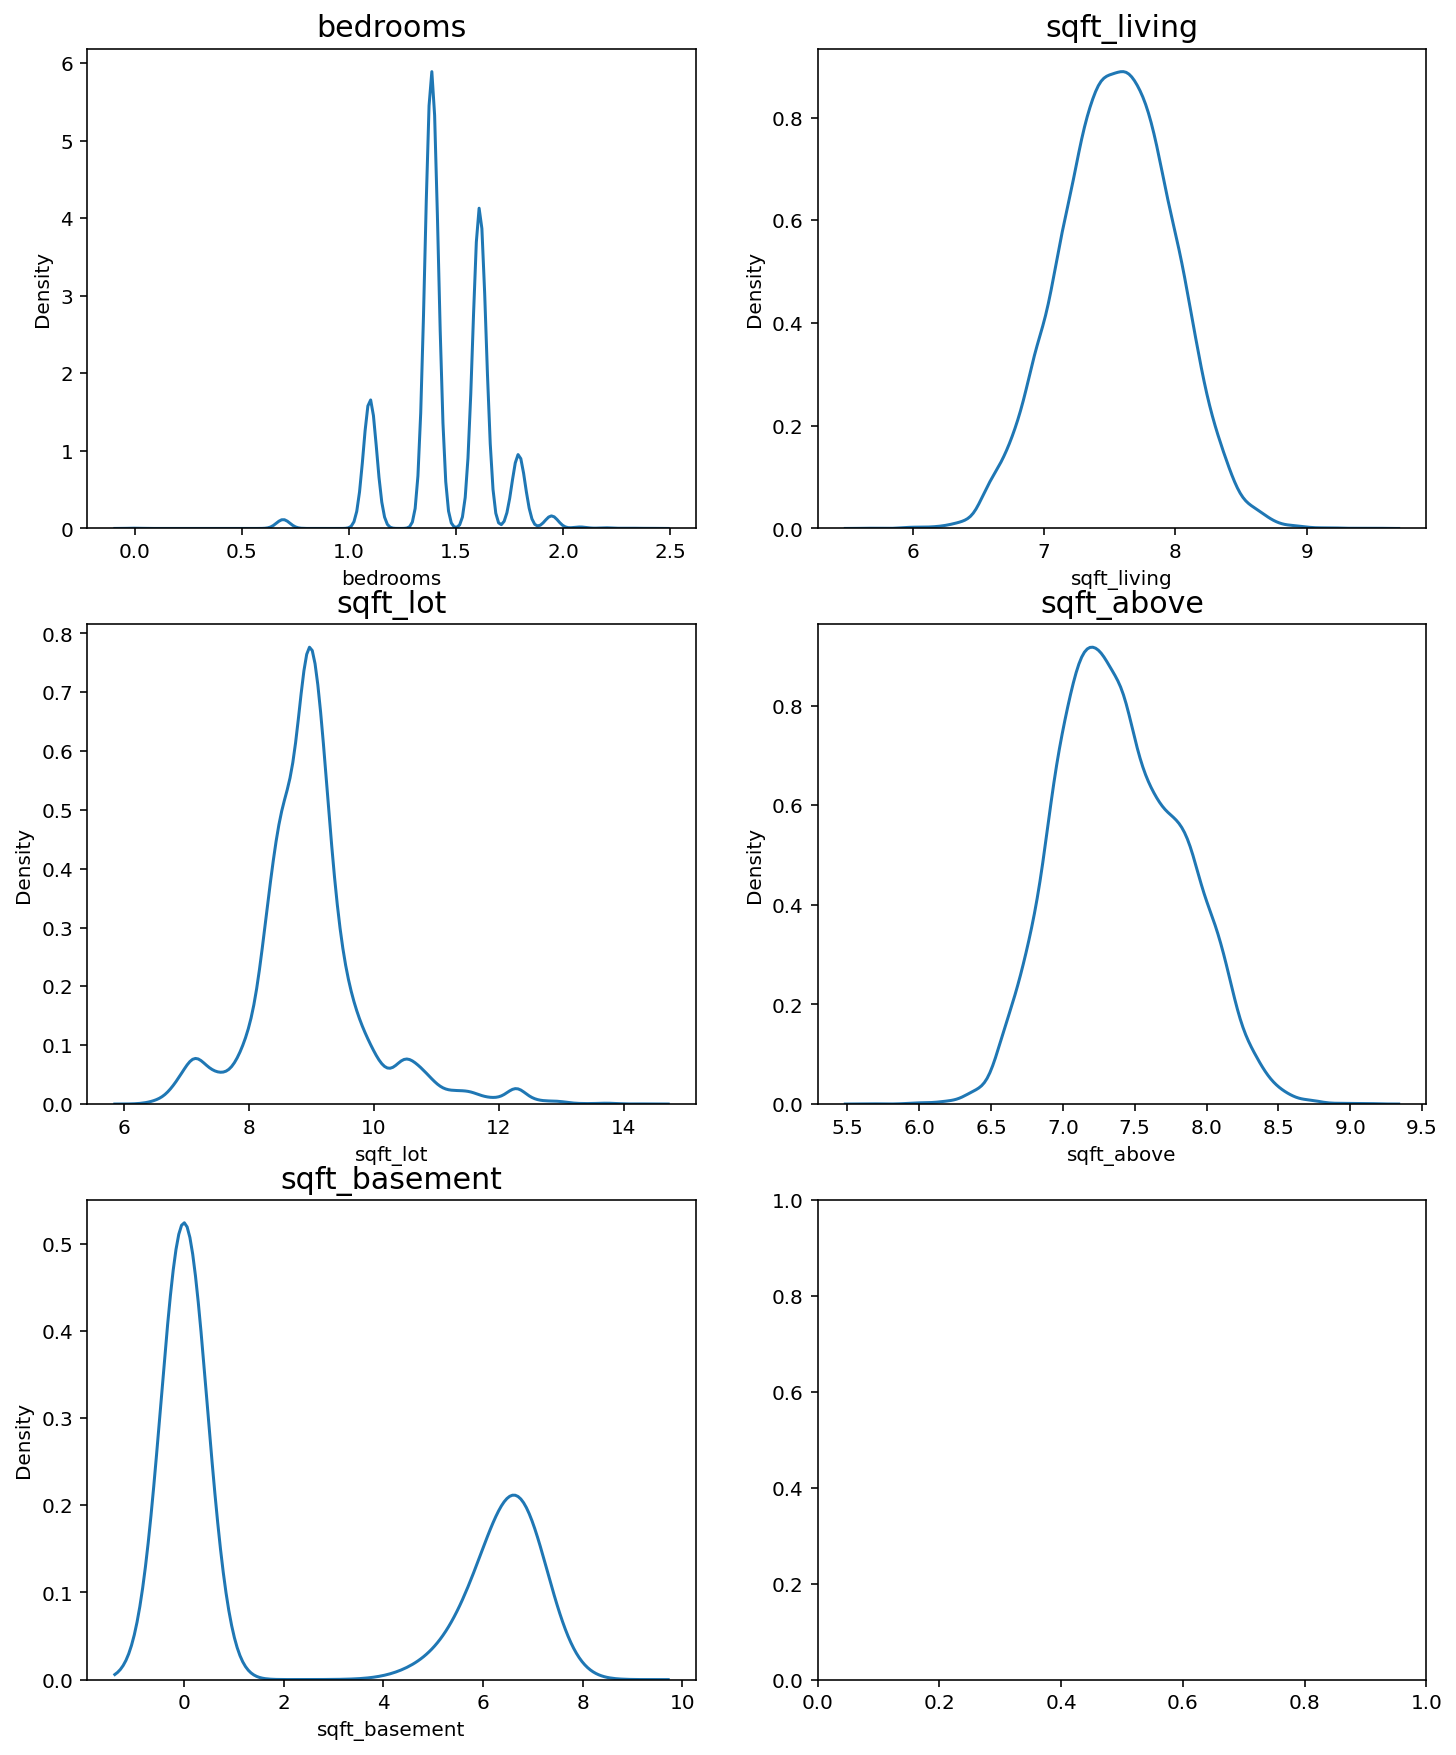

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

### MODEL

In [16]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
# 위에서 log1p() 변환해서 확인했던 값을 다시 expm1() 사용해서 원래대로 변환
print('변환')

변환


In [17]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None None값을 주게되면 모델 내부에서 임의로 선택합니다.  
random_state=2020  #  우리는 이렇게 고정값 세팅하기로 함. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('model')

model


### RMSE Scores

In [18]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

RMSE
GradientBoostingRegressor  128360.173766
RandomForestRegressor      125325.083751
LGBMRegressor              111906.947718
XGBRegressor               110319.301793

### 그리드를 이용해서 하이퍼파라미터 튜닝해보기!

In [19]:
from sklearn.model_selection import GridSearchCV

print('튜닝')

튜닝


In [20]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [21]:
model = LGBMRegressor(random_state=random_state)

print('뿡!')

뿡!


In [22]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.2s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [23]:
grid_model.cv_results_

{'mean_fit_time': array([0.07368212, 0.07451711, 0.13810291, 0.22111921]),
 'std_fit_time': array([0.01151407, 0.00327516, 0.0040381 , 0.00602523]),
 'mean_score_time': array([0.00528612, 0.00652299, 0.00926476, 0.01550584]),
 'std_score_time': array([9.71866891e-05, 2.04493248e-04, 4.35578151e-05, 9.73260004e-04]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885212, -0.02664695]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041411, -0.02795762]),
 'split2_test_score': ar

In [24]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [25]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339763, -0.05502319, -0.02917323, -0.02702383])

In [26]:
results = pd.DataFrame(params)
results['score'] = score

results

max_depth  n_estimators     score
0          1            50 -0.073398
1          1           100 -0.055023
2         10            50 -0.029173
3         10           100 -0.027024

In [27]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

max_depth  n_estimators     score      RMSE
0          1            50 -0.073398  0.270920
1          1           100 -0.055023  0.234570
2         10            50 -0.029173  0.170802
3         10           100 -0.027024  0.164389

In [28]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

max_depth  n_estimators     score     RMSLE
0          1            50 -0.073398  0.270920
1          1           100 -0.055023  0.234570
2         10            50 -0.029173  0.170802
3         10           100 -0.027024  0.164389

In [29]:
results = results.sort_values('RMSLE')
results

max_depth  n_estimators     score     RMSLE
3         10           100 -0.027024  0.164389
2         10            50 -0.029173  0.170802
1          1           100 -0.055023  0.234570
0          1            50 -0.073398  0.270920

### 그리드를 사용해서 하이퍼파라미터 튜닝 함수 만들기!
##### 위에 있는 복잡한 과정들을 함수로 정의 함 

In [30]:
# def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
#     # GridSearchCV 모델로 초기화
#     grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
#                               cv=5, verbose=verbose, n_jobs=n_jobs)

#     # 모델 fitting
#     grid_model.fit(train, y)

#     # 결과값 저장
#     params = grid_model.cv_results_['params']
#     score = grid_model.cv_results_['mean_test_score']

#     # 데이터 프레임 생성
#     results = pd.DataFrame(params)
#     results['score'] = score

#     # RMSLE 값 계산 후 정렬
#     results['RMSLE'] = np.sqrt(-1 * results['score'])
#     results = results.sort_values('RMSLE')

#     return results

### 저장 하는 함수 ! 

In [31]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.7s finished


max_depth  n_estimators     score     RMSLE
3         10           100 -0.027024  0.164389
2         10            50 -0.029173  0.170802
1          1           100 -0.055023  0.234570
0          1            50 -0.073398  0.270920

In [32]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.55657447, 13.59362374, 14.32797567, ..., 14.01930487,
       13.84405935, 13.89509342])

In [33]:
prediction = np.expm1(prediction)
prediction

array([ 771871.35606631,  801005.0158848 , 1669400.39658668, ...,
       1226044.94579271, 1028959.2165    , 1082834.27641627])

In [34]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [35]:
submission['price'] = prediction
submission.head()

id         price
0  15035  7.718714e+05
1  15036  8.010050e+05
2  15037  1.669400e+06
3  15038  5.476823e+05
4  15039  5.963883e+05

In [36]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel-dj12/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


#### 위 코드를 함수로 정의 

In [37]:
# def save_submission(model, train, y, test, model_name, rmsle=None):
#     model.fit(train, y)
#     prediction = model.predict(test)
#     prediction = np.expm1(prediction)
#     data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
#     submission_path = join(data_dir, 'sample_submission.csv')
#     submission = pd.read_csv(submission_path)
#     submission['price'] = prediction
#     submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
#     submission.to_csv(submission_csv_path, index=False)
#     print('{} saved!'.format(submission_csv_path))

In [38]:
# save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

# 프로젝트를 마치며...

### 데이터 전처리 부터 시각화 하는 그래프 함수들 계속 해서 사용해보니 코드들이 이해가 되기 시작했다. 처음에는 노드을 완료 하고 나서 캐글 115888 점수가 나와서 튜닝해볼수 있는 모델 클래스 인자 들을 조금씩 건들여봤는데 갑자기 500000만 이상으로 확 뛰어서 그냥 처음 했던 걸로 수정했다. 

### 다음번에는 데이터 전처리 부분을 잘 건들여서 데이터를 수정 하여 모델 파라미터와 하이퍼파라미터 동시에 수정하여 적용해보아야겠다. 

### 이번 익스플로레이션은 데이터 분석 과 모델들을 이용하여 정확도를 올리는 방법을 배우게 되는 공부였다.